# A full SED-Fitting example

This tutorial goes through the things that need to be done to fit the observed spectral energy distributions (SEDs) of galaxies. This is different from SED fitting codes that use a sampler while fitting to create their posteriors, in the sense that we pre-sample the prior volume prior to fitting, trading space for time complexity. This results in a moderately lengthy initialization period where the method generates an atlas of parameters drawn from the priors and SEDs corresponding to these parameters with a user-specified filter-set, which can then be used to fit any number of SEDs in an extremely short amount of time. (Further iterations of the code are also planned to include variants with live samplers for edge-cases and objects with pathological likelihood surfaces.)

The atlas essentially provides a coarse mapping from the galaxy's stellar population parameters (stellar mass, SFR, star formation history, dust attenuation, metallicity, and redshift) to their corresponding SEDs.   

Instantiate the module, making sure you have all the prerequisite packages (especially python-fsps and george) installed. Don't worry if the initial import takes a few minutes, because it’s initializing its FSPS backend.

If you need to change any of the FSPS parameters, do so using `db.mocksp.params['key'] = value`, consulting the [python-fsps](http://dfm.io/python-fsps/current/stellarpop_api/#api-reference) API for reference. 

### Note: If you're using a version older than 0.1.4, the syntax for computing atlases has changed. Please update to the current version to be consistent with the tutorial and examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dense_basis as db
print('DB version: ',db.__version__)

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
DB version:  0.1.8


# Prerequisites to fitting: 

If you’re fitting photometry, put your photometric filter transmission curves in a folder somewhere and make a list of filter curves with the paths to each filter. You’ll need to pass `filter_list` and `filt_dir` as arguments to the code to generate SEDs corresponding to a given parameter set. 

The `db.plot_filterset()` function can be used to visualize the set of filter curves used to make SEDs. Let’s load a filter list corresponding to the CANDELS GOODS-South photometric catalog for now:

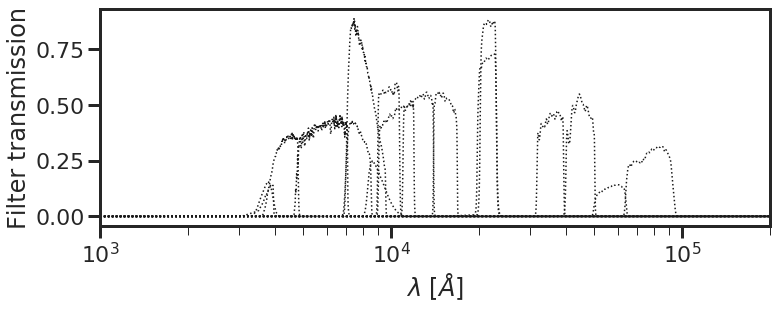

In [2]:
filter_list = 'filter_list_goodss.dat'
filt_dir = 'internal' # path to directory containing filter list
db.plot_filterset(filter_list = filter_list, filt_dir = filt_dir)

### 1. Instantiate a Priors() object

The next step is to generate a template atlas that you will use for fitting. The advantage of doing this is that we trade time-complexity for space, which is usually much more abundant, and it only needs to be done once to fit a large dataset. Before doing this, however, we need a set of priors that we can draw from to generate this atlas. This is done using the `db.Priors()` class:

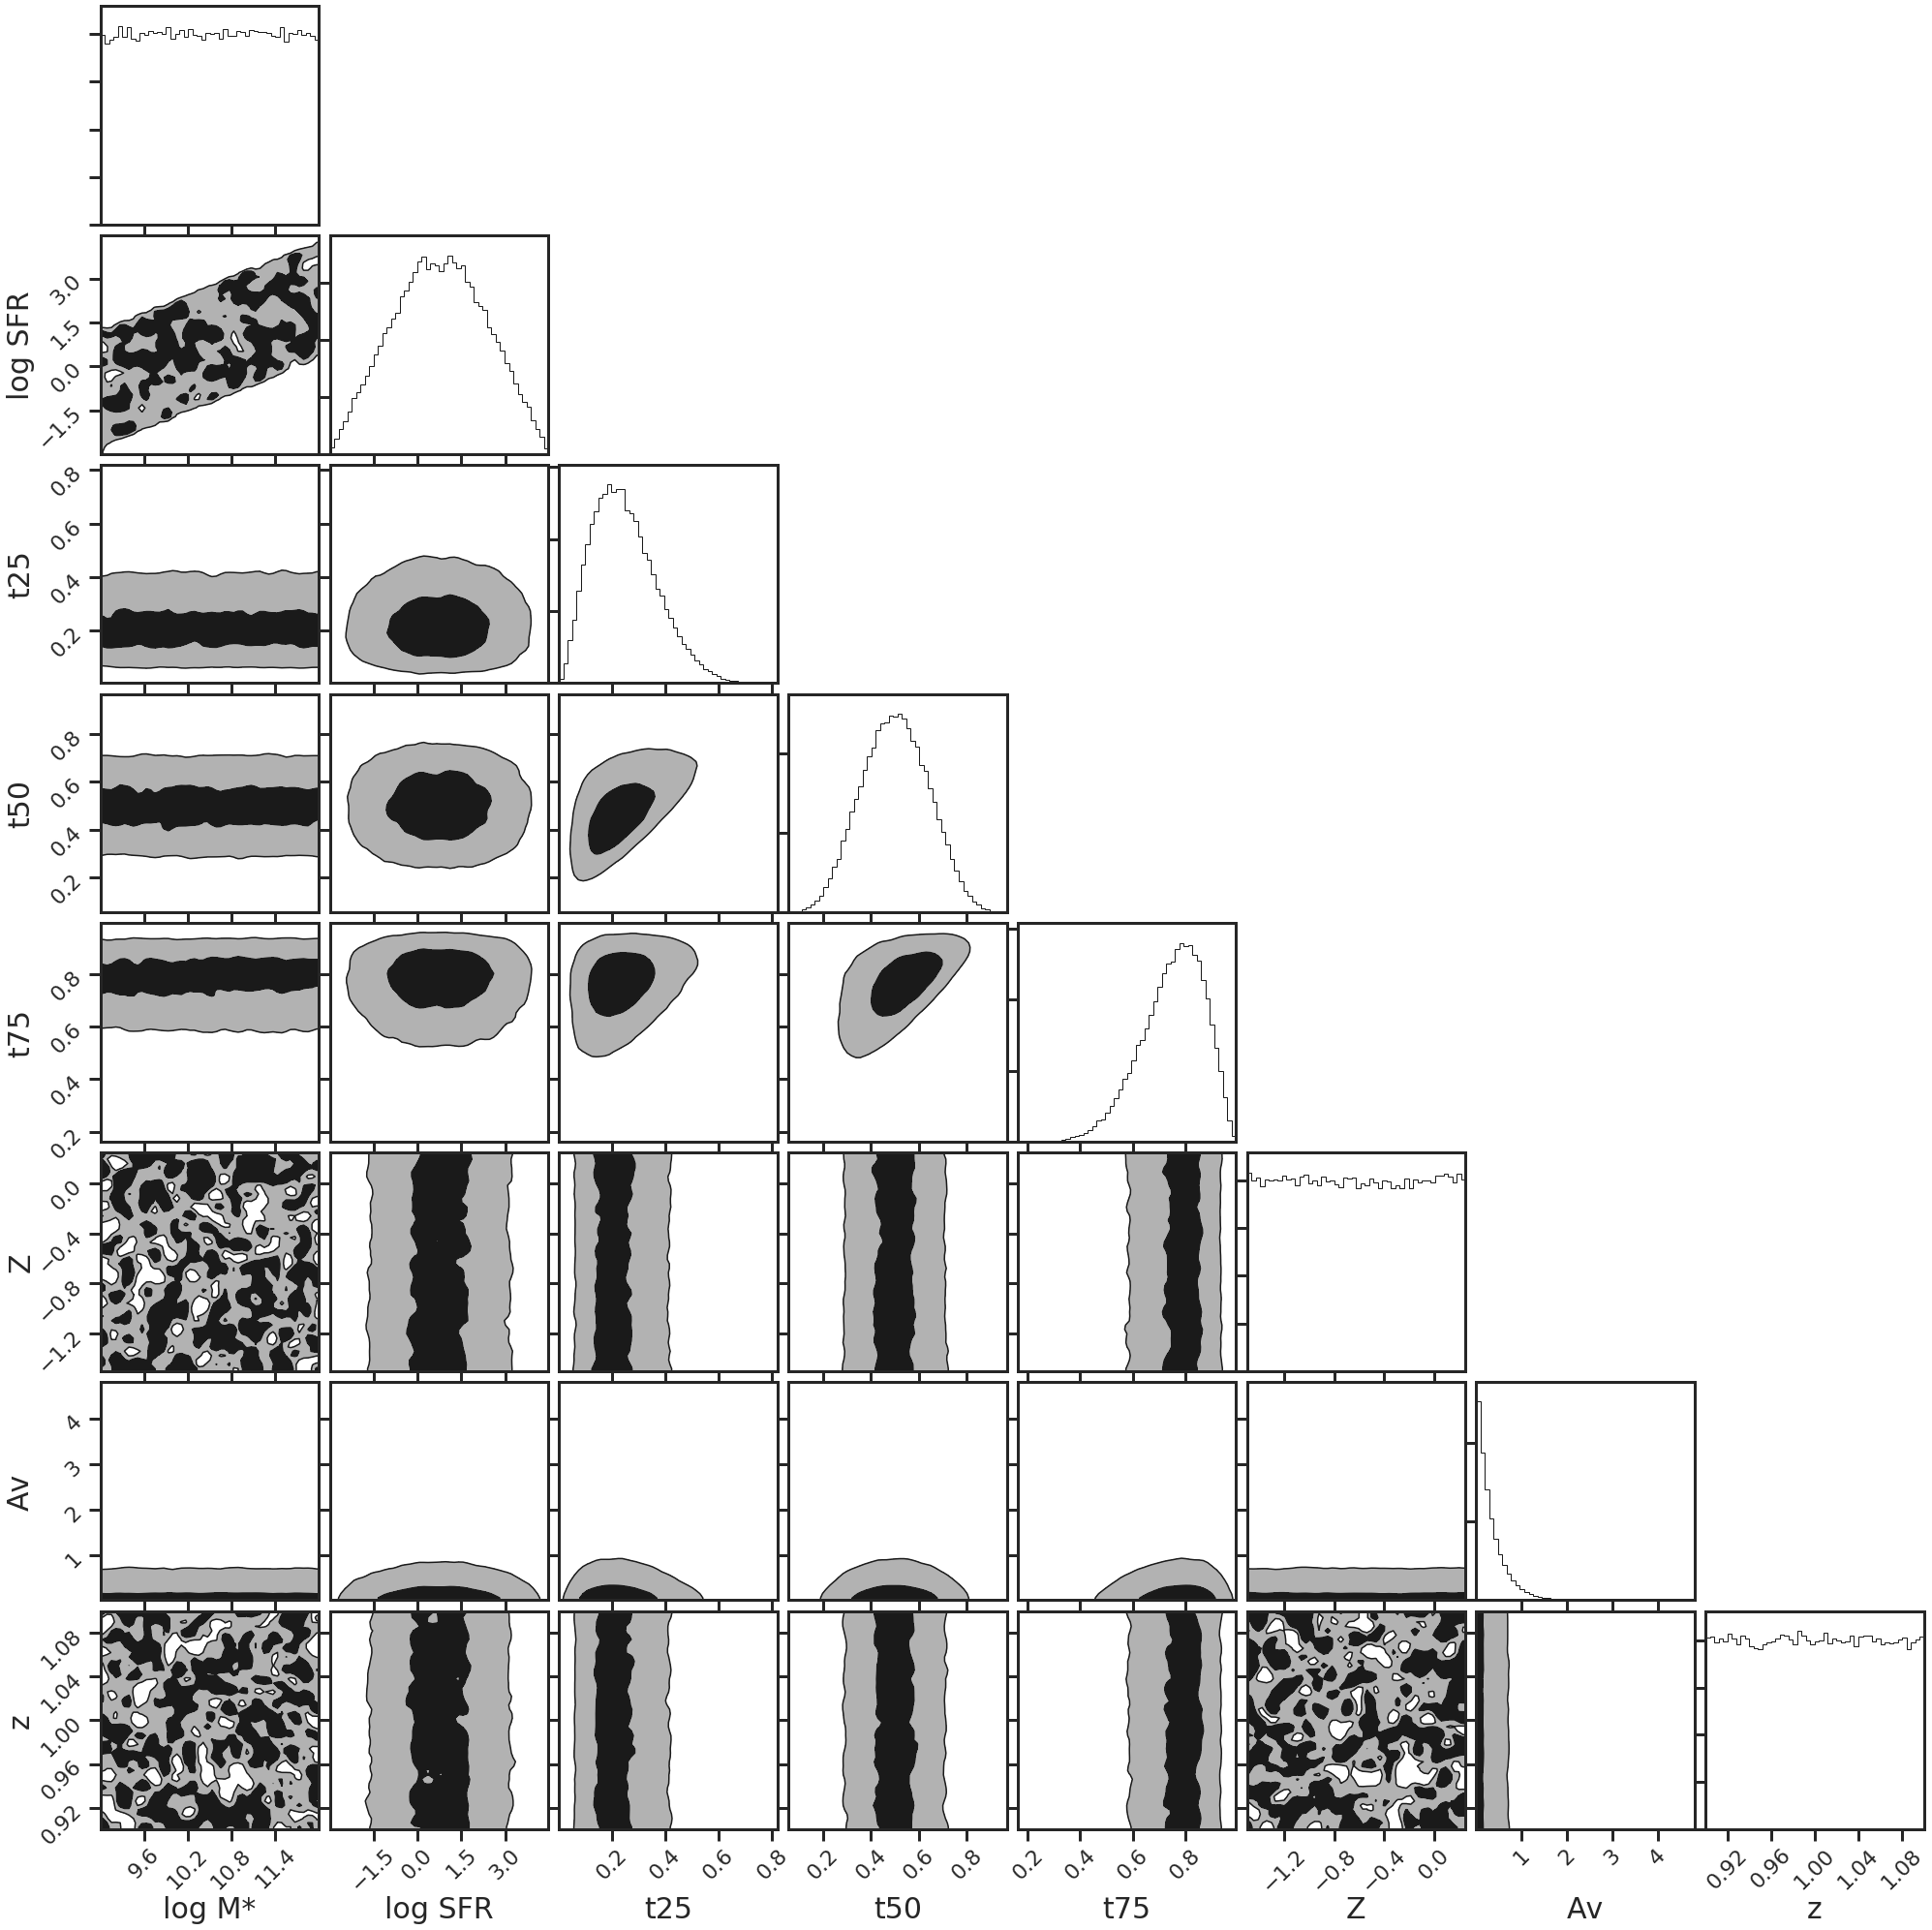

In [3]:
priors = db.Priors()
priors.tx_alpha = 3.0
priors.plot_prior_distributions()

### 2. Generate an atlas of parameters drawn from the prior and their corresponding SEDs.

Now we can use the priors object to generate the atlas. The important arguments here are the size of the atlas (`N_pregrid`), which samples from the overall multidimensional prior distributions, and the number of SFH parameters (`priors.Nparam`). The generated atlas is then stored in a local `/pregrids` folder with the user-specified fname within the current working directory. Please specify a different path using the `path` argument if you would like it to be stored in a different place. The first few SEDs take time to compute because every time FSPS encounters a new metallicity value it needs to load a grid into memory. This happens only once, and when it is done, the atlas generation process speeds up considerably.

In [4]:
fname = 'test_atlas'
N_pregrid = 10000
priors.Nparam = 3
path = 'pregrids/'
db.generate_atlas(N_pregrid = N_pregrid, 
                  priors = priors, 
                  fname = fname, store=True, path='pregrids/',
                  filter_list = filter_list, filt_dir = filt_dir)

  0%|          | 0/10000 [00:00<?, ?it/s]

generating atlas with: 
3  tx parameters,  sSFRflat  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.


100%|██████████| 10000/10000 [13:21<00:00, 12.48it/s]


Path exists. Saved atlas at : pregrids/test_atlas_10000_Nparam_3.dbatlas


### 3. Generate a mock SED to be fit.

To illustrate the SED fitting procedure, let’s generate a mock star formation history (SFH) to recover. This can be done by sampling our priors for an SFH-tuple and then converting it to a SFR-vs-time curve using the `db.tuple_to_sfh()` command. We can then generate its corresponding spectrum, and multiply the spectrum with our prespecified filter-set to get the corresponding SED. 

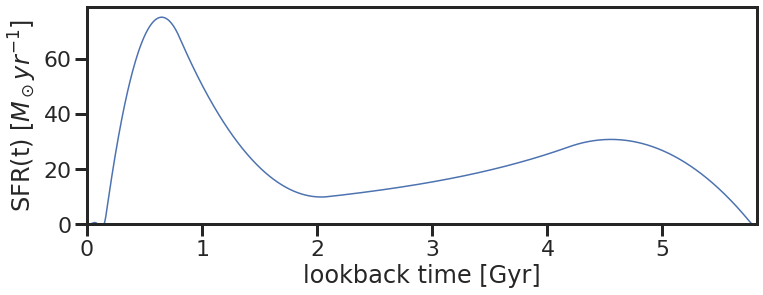

In [5]:
# sample from the prior space to get parameters 
rand_sfh_tuple, rand_Z, rand_Av, rand_z = priors.sample_all_params(random_seed = 1)

specdetails = [rand_sfh_tuple, rand_Av, rand_Z, rand_z]

# generate an SFH corresponding to the SFH-tuple and see how it looks: 
rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = rand_z) 
fig = db.plot_sfh(rand_time, rand_sfh, lookback=True) 
sfh_truths = [rand_time, rand_sfh]

# generate a corresponding spectrum and multiply by filter curves to get the SED: 
obs_sed = db.makespec(specdetails, priors, db.mocksp, db.cosmo, 
                             filter_list=filter_list,filt_dir=filt_dir,input_sfh=False)
obs_err = obs_sed * 0.1 # S/N of 10

# store the true stellar mass and SFR
mstar_true = np.log10(db.mocksp.stellar_mass)
sfr_true = np.log10(db.mocksp.sfr)

sed_truths = (mstar_true, sfr_true, rand_sfh_tuple[3:], rand_Z, rand_Av, rand_z)
sed_truths = np.hstack(sed_truths)

# SED fitting with the dense_basis package:

### 4. Load the previously generated atlas:

Step 2 is extremely beneficial in fitting large datasets, since the atlas needs to be generated only once and can be used for fitting as many SEDs as needed using the brute-force Bayesian approach. Having generated this dataset, now an arbitrary SED (`obs_sed`, and its errors `obs_err`) can be fit using the previously generated atlas.

In [6]:
# load the atlas 
atlas = db.load_atlas(fname, N_pregrid = N_pregrid, N_param = priors.Nparam, path = path) 

# pass the atlas and the observed SED + uncertainties into the fitter, 
sedfit = db.SedFit(obs_sed, obs_err, atlas, fit_mask=[])

# evaluate_likelihood returns the likelihood for each SED in the atlas and the norm value to
# best match the observed SED with the atlas.
sedfit.evaluate_likelihood()

# evaluate_posterior_percentiles calculates the 16,50,84th percentiles for 
# the physical parameters - stellar mass, SFR, tx, dust, metallicity and redshift
sedfit.evaluate_posterior_percentiles()

### 5. Fit the SED and visualize the parameter posteriors:

If we are interested in the full posteriors of the fit, this can be visualized by making the fitter return the chi2 array and then computing the full posteriors as prior*likelihood. Let’s see how it compares to the truth:

In [7]:
%timeit sedfit.evaluate_likelihood()

6.76 ms ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print('log Stellar Mass: %.2f' %sedfit.mstar[0])
print('log SFR: %.2f' %sedfit.sfr[0])

log Stellar Mass: 11.06
log SFR: -0.03


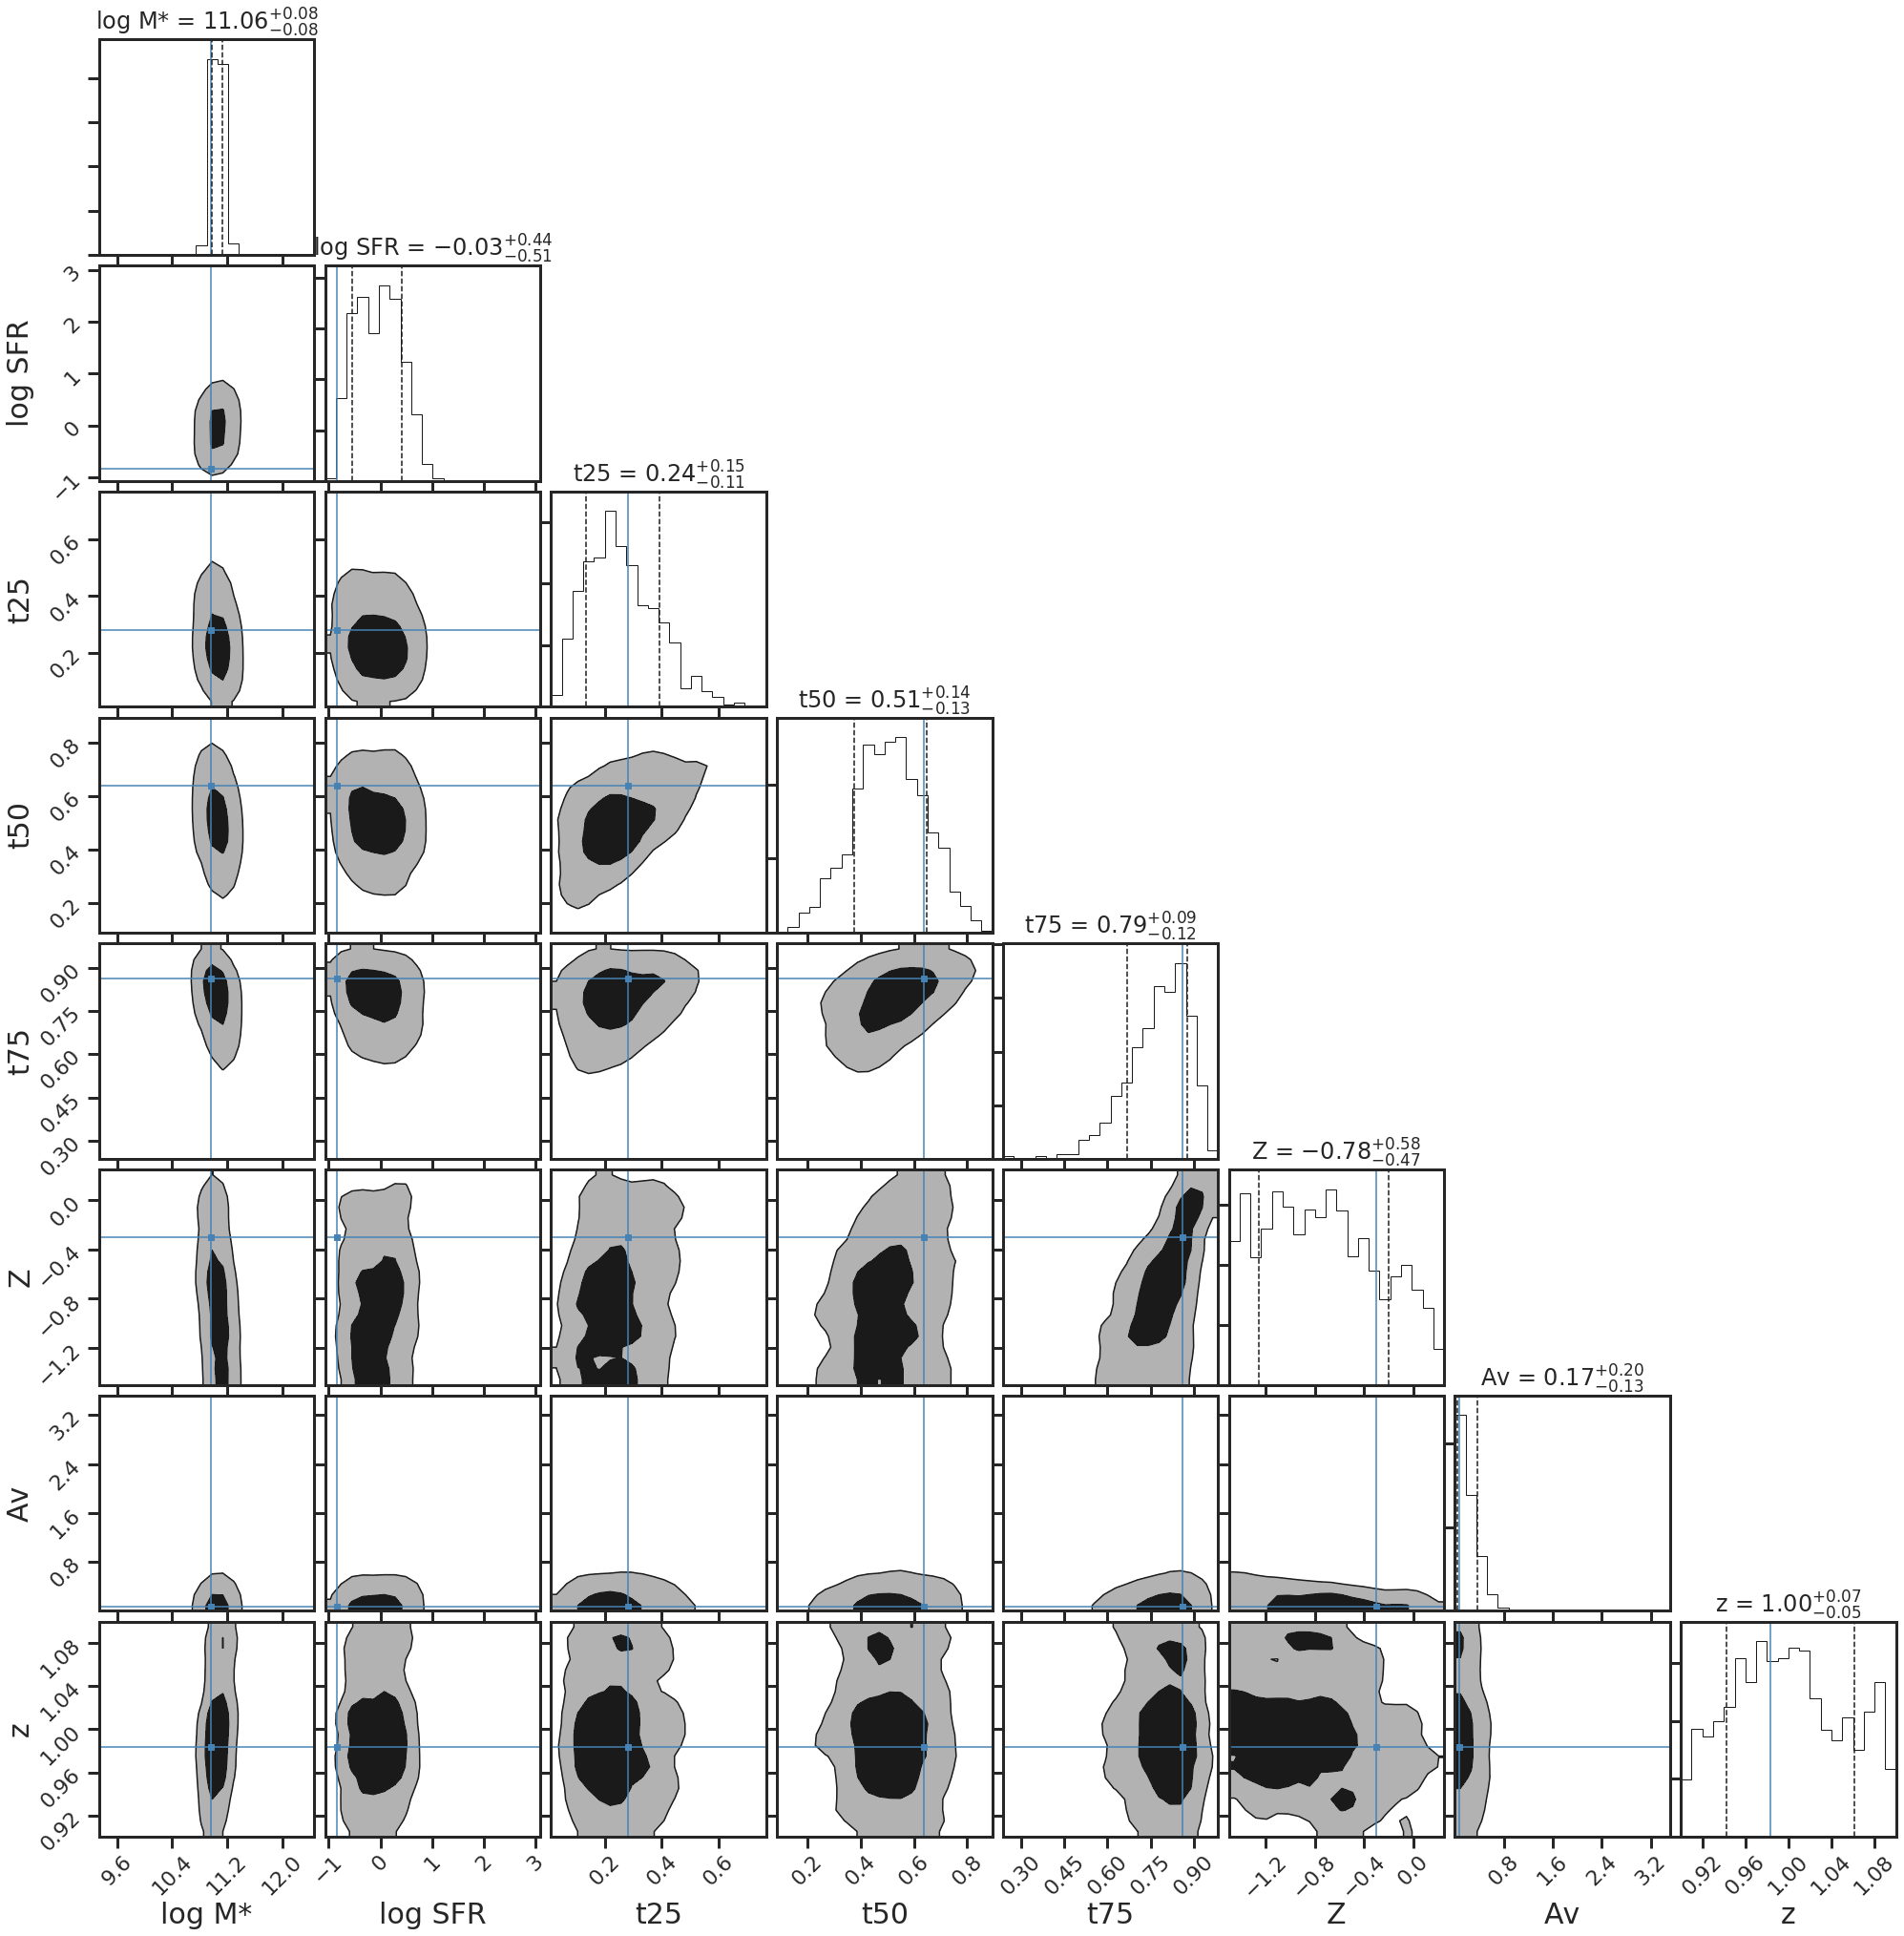

In [9]:
sedfit.plot_posteriors(truths=sed_truths)
plt.show()

### 6. Visualize the posterior SFH and spectrum:

Finally, we can also plot the posterior SFH and see how it compares to the true SFH:

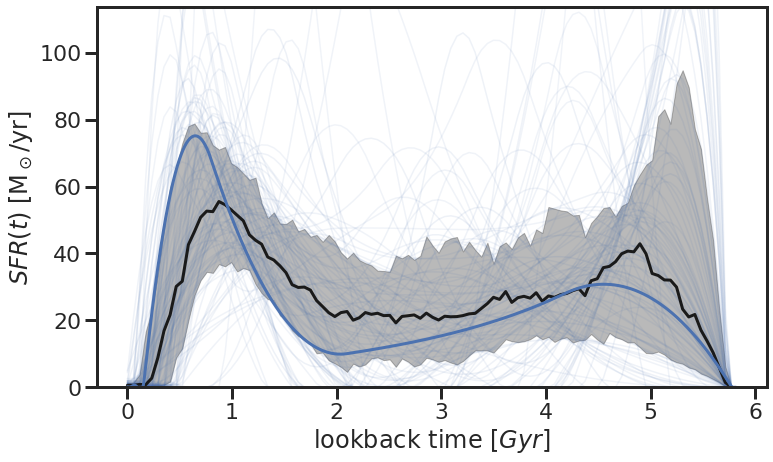

In [10]:
sedfit.plot_posterior_SFH(sedfit.z[0])
plt.plot(np.amax(sfh_truths[0]) - sfh_truths[0],sfh_truths[1],lw=3)
plt.show()

In [11]:
# deprecated code - use if you're using v.0.1.5 or older

# db.plot_SFH_posterior(chi2_array, norm_fac, obs_sed, atlas, 
#                          truths = sfh_truths, sfh_threshold = 0.7)

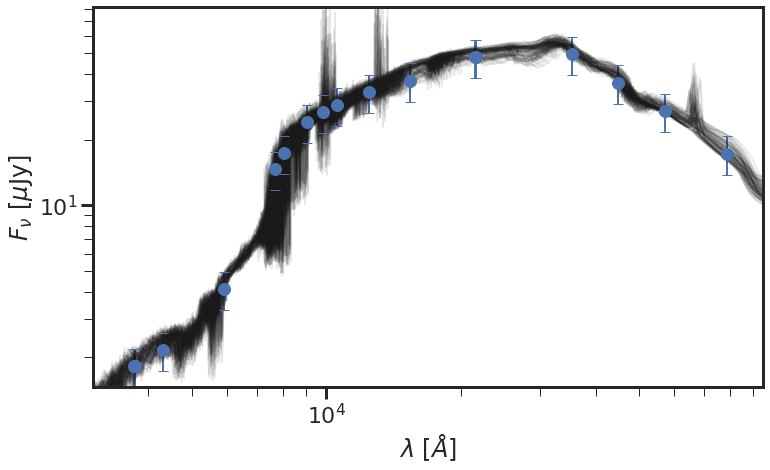

In [12]:
centers_goods_s = np.array([3734,3722,4317,5918,7693,8047,9055,9851,10550,12486,15370,21605,21463,35508,44960,57245,78840])
sedfit.plot_posterior_spec(centers_goods_s, priors)
plt.show()

### 7. Compare with MCMC results

The dense_basis package also has an extremely fast MCMC sampler now available, for when the uncertainties need to be sampled more robustly, multi-modal solutions further investigated, or when SEDs might lie on the edge of the prior space. This uses the excellent [emcee](https://emcee.readthedocs.io/) package (so make sure that's installed before you try to run the following), and returns an `emcee.sampler` object. Let's try running this with the galaxy above and see what we get for the posteriors.

100%|██████████| 10000/10000 [00:44<00:00, 225.26it/s]


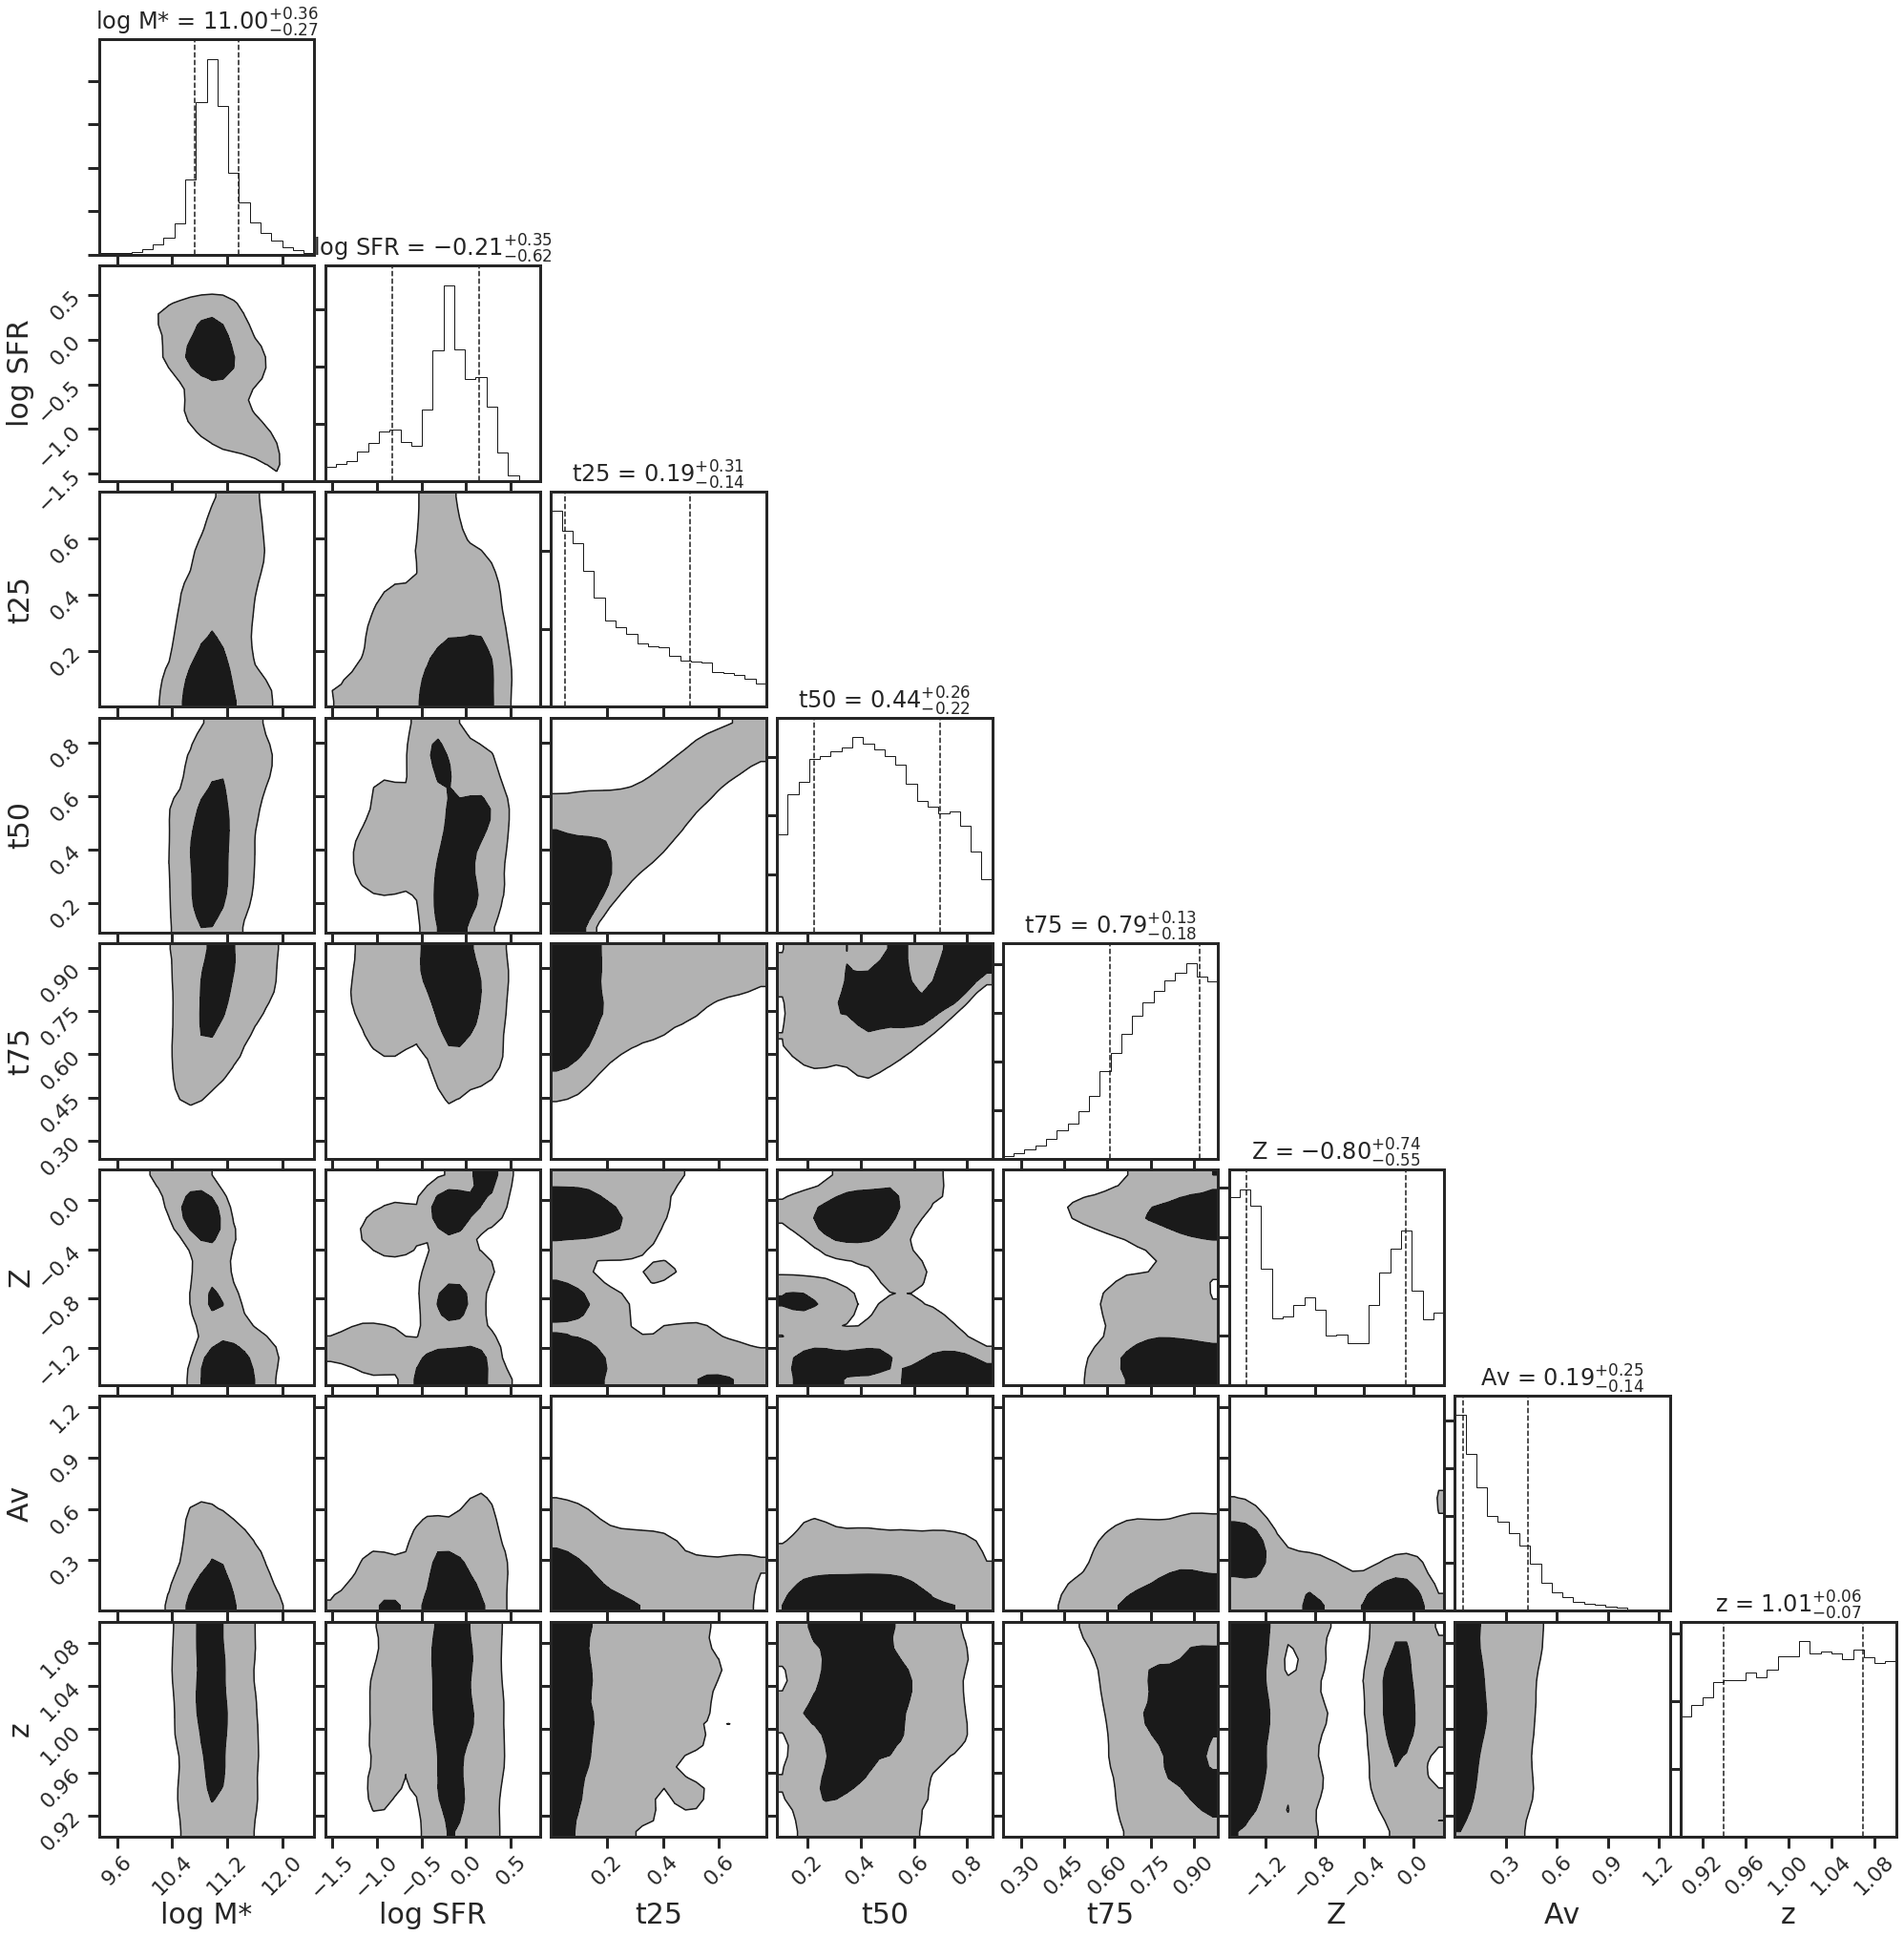

In [13]:
sampler = db.run_emceesampler(obs_sed, obs_err, atlas, epochs=10000, plot_posteriors=True)